# Online VMP of AR(p)
State space model
\begin{align*}
    &\mathbf{x}_t = \mathbf{A}\mathbf{x}_{t-1} + \mathbf{p}_t \quad \mathbf{p}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I}\gamma^{-1}) \\
    &y_t = \mathbf{c}^\text{T}\mathbf{x}_t
\end{align*}

or

\begin{align*}
     &p(\mathbf{x}_t\,|\,\mathbf{x}_{t-1},\mathbf{a},\gamma) = \mathcal{N}\left(\mathbf{x}_t \;\middle|\; \mathbf{A}\mathbf{x}_{t-1}, \mathbf{I}\gamma^{-1} \right)\\
    &p(y_t\,|\,\mathbf{x}_{t}) = \mathcal{N}\left(y_t \;\middle|\;\mathbf{c}^\text{T}\mathbf{x}_t, \epsilon \right)
\end{align*}

where

\begin{align*}
    &\mathbf{x}_t = (x_t, x_{t-1}, \dots, x_{t-p+1})^\text{T} \quad \mathbf{x}_{t-1} = (x_{t-1}, x_{t-2}, \dots, x_{t-p})^\text{T} 
    \\ \\
    &\mathbf{A} = 
    \begin{bmatrix}
        a_1 & a_2 & a_3 & \dots & a_p \\
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 0
    \end{bmatrix}
    =
    \begin{bmatrix}
         \mathbf{a}^\text{T} \\
         \mathbf{I}_{p-1} \quad \mathbf{0}
    \end{bmatrix}
    \\ \\
    &\mathbf{I} = \mathbf{I}_p = 
    \begin{bmatrix}
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 1
    \end{bmatrix} \\
    &\epsilon = 1\text{e}-12
\end{align*}

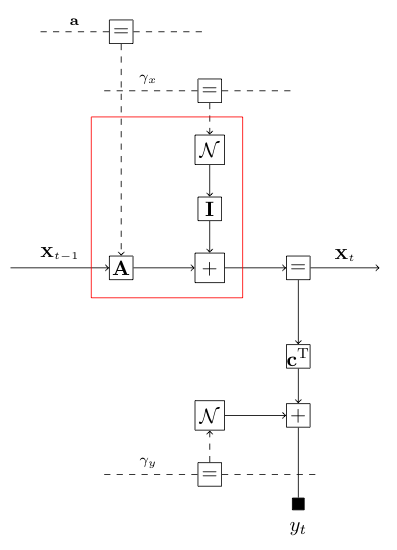

In [236]:
using Images
img = load("../ffgs/AR-online.png")

We are interested in joint estimation of the AR coefficients $\mathbf{a}$ and process noise variance $\gamma^{-1}$.

In [237]:
using ProgressMeter
using Revise
using Plots
using ForneyLab
using LaTeXStrings
using Random
include( "../AR-node/autoregression.jl")
include("../AR-node/rules_prototypes.jl")
include("../AR-node/vmp_rules.jl")
include( "../AR-node/observationAR.jl")
# helpers for evaluation of the model
include("../helpers/functions.jl")
# module to generate data for AR
include("../data/ARdata.jl")
import Main.ARdata: loadAR, generateAR, writeAR, readAR
import LinearAlgebra.I, LinearAlgebra.Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision

In [238]:
Random.seed!(24)

# Define the order and data
ARorder = 2
diagAR(dim) = Matrix{Float64}(I, dim, dim)

# AR data
v_x = 1.0 # process noise variance
coefs, dataAR = generateAR(1000, ARorder, nvar=v_x)
#dataAR = loadAR("../data/temperature.csv", 5, col=:Temp, delim=",")

# Observations
y = [x[1] for x in dataAR];

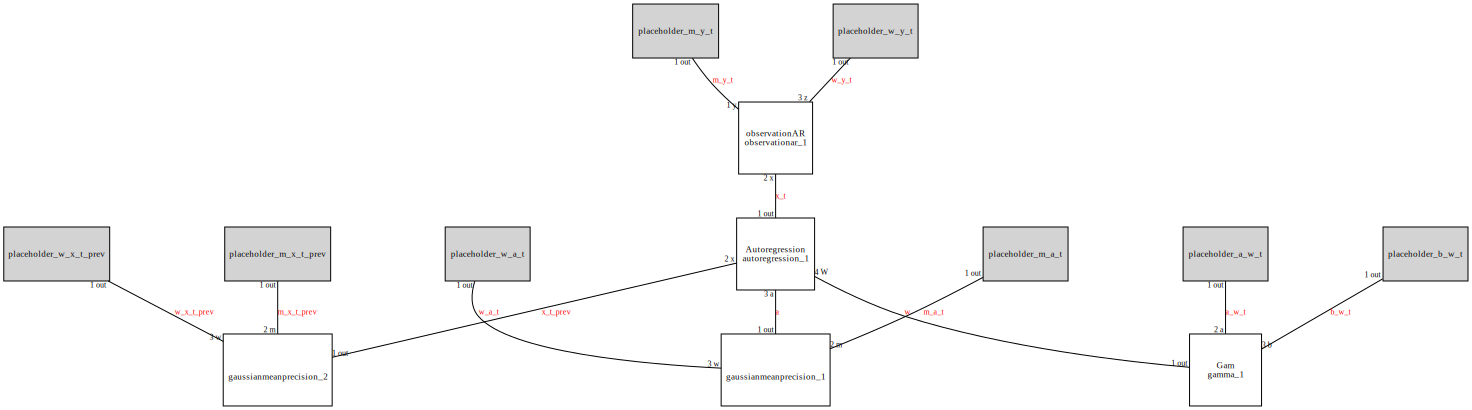

In [239]:
g = FactorGraph()

# declare priors as random variables
@RV m_x_t_prev
@RV w_x_t_prev
@RV m_a_t
@RV w_a_t
@RV m_y_t
@RV w_y_t
@RV a_w_t
@RV b_w_t

@RV a ~ GaussianMeanPrecision(m_a_t, w_a_t)
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV w ~ Gamma(a_w_t, b_w_t)
@RV x_t = AR(a, x_t_prev, w)
observationAR(m_y_t, x_t, w_y_t)

# Placeholders for prior
placeholder(m_a_t, :m_a_t, dims=(ARorder,))
placeholder(w_a_t, :w_a_t, dims=(ARorder, ARorder))
placeholder(m_x_t_prev, :m_x_t_prev, dims=(ARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(ARorder, ARorder))
placeholder(a_w_t, :a_w_t)
placeholder(b_w_t, :b_w_t)

# Placeholder for data
placeholder(m_y_t, :m_y_t)
placeholder(w_y_t, :w_y_t)

ForneyLab.draw(g)

In [240]:
# Specify recognition factorization
q = RecognitionFactorization(a, x_t, w, ids=[:A :X_t :W])

# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)
algoF = freeEnergyAlgorithm()

# Load algorithms
eval(Meta.parse(algo))
eval(Meta.parse(algoF))

freeEnergy (generic function with 1 method)

In [241]:
# Define values for prior statistics
m_a_0 = ones(ARorder)
w_a_0 = diagAR(ARorder)
m_x_prev_0 = ones(ARorder)
w_x_prev_0 = diagAR(ARorder)
a_w_0 = 0.001
b_w_0 = 0.001

# Storage for predictions
means = []
vars = []

# Storage for MSE and FE 
MSEsAR = []
FAR = []
# we exclude last p (ARorder) samples for model evaluation purposes
n_samples = length(y) - ARorder 

# Storage
m_x = Vector{Vector{Float64}}(undef, n_samples)
w_x = Vector{Array{Float64, 2}}(undef, n_samples)
m_a = Vector{Vector{Float64}}(undef, n_samples)
w_a = Vector{Array{Float64, 2}}(undef, n_samples)
a_w = Vector{Float64}(undef, n_samples)
b_w = Vector{Float64}(undef, n_samples)

# Inits
m_x_t_prev_min = m_x_prev_0
w_x_t_prev_min = w_x_prev_0
m_a_min = m_a_0
w_a_min = w_a_0
a_w_min = a_w_0
b_w_min = b_w_0;

In [242]:
marginals = Dict()
# VMP iterations
n_its = 5

# making first dummy predictions
push!(means, m_a_min'm_x_t_prev_min)
push!(vars, a_w_min/b_w_min)

p = Progress(length(y), 1, "Observed ")
window = 5

for t in 1:n_samples
    predictions = predict(m_a_min, m_x_t_prev_min, ARorder)
    push!(MSEsAR, mse(predictions, y[t:t+ARorder-1]))
    update!(p, t)
    marginals[:a] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_a_min, w=w_a_min)
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:w] = ProbabilityDistribution(Univariate, Gamma, a=a_w_min, b=b_w_min)
    global m_x_t_prev_min, w_x_t_prev_min, m_a_min, w_a_t_min, a_w_min, b_w_min, data
    for i = 1:n_its
        data = Dict(:m_y_t => y[t],
                    :w_y_t => huge,
                    :m_a_t => m_a_min,
                    :w_a_t => w_a_min,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min,
                    :a_w_t => a_w_min,
                    :b_w_t => b_w_min)
        stepX_t!(data, marginals)
        stepA!(data, marginals)
        stepW!(data, marginals)
        m_a[t] = unsafeMean(marginals[:a])
        w_a[t] = unsafePrecision(marginals[:a])
        m_x[t] = unsafeMean(marginals[:x_t])
        w_x[t] = unsafePrecision(marginals[:x_t])
        a_w[t] = marginals[:w].params[:a]
        b_w[t] = marginals[:w].params[:b]
        m_a_min = m_a[t]
        w_a_min = w_a[t]
        m_x_t_prev_min = m_x[t]
        w_x_t_prev_min = w_x[t]
        a_w_t_min = a_w[t]
        b_w_t_min = b_w[t]
    end
    # prediction of the next value
    m = m_a_min'm_x_t_prev_min
    v = mean(marginals[:w])^-1
    push!(means, m)
    push!(vars, v)
    push!(FAR, (freeEnergy(data, marginals))) 
end

Observed  37%|███████████████▌                          |  ETA: 0:00:02

In [243]:
println("Coefs")
println("real = ", coefs)
println("estimated mean = ", unsafeMean(marginals[:a]))
println("===============")
println("Noise")
println("real variance = ", v_x)
println("estimated variance = ", unsafeMean(marginals[:w])^-1)

Coefs
real = [1.66227, -0.835983]
estimated mean = [1.25986, -0.396957]
Noise
real variance = 1.0
estimated variance = 1.1533698239607997


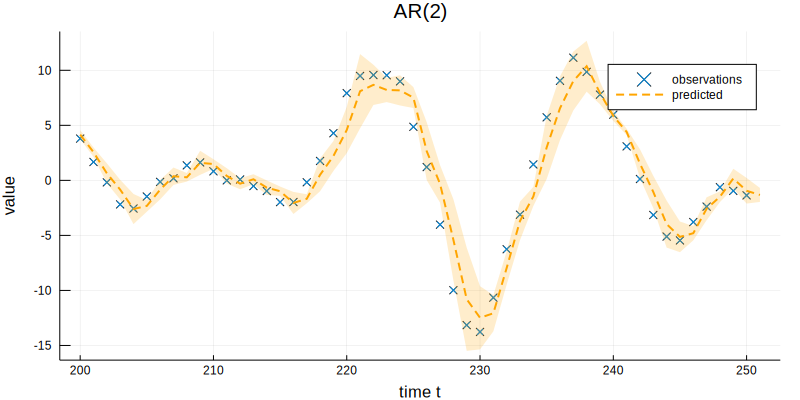

In [265]:
from = 200
upto = 250
scale = 1.0


scatter(collect(from:upto), y[from:upto], label="observations", title="AR($ARorder)", size=(800, 400), 
        markershape = :xcross, markeralpha = 0.9, markersize = 3)
plot!(collect(from:upto+1), means[from:upto+1], ribbon=(sqrt.(vars[from:upto+1]), sqrt.(vars[from:upto+1])),
          linestyle=:dash, linewidth = 2,
          color=:orange,
          fillalpha = 0.2,
          fillcolor = :orange,
          label="predicted", xlabel="time t", ylabel="value",
          legend=true)

# Random walk model 
As a benchamrk, we use the following RW model.
\begin{align*}
    &x_t = x_{t-1} + p_t \quad p_t \sim \mathcal{N}(0, \gamma_x^{-1}) \\
    &y_t = x_t + m_t \quad m_t \sim \mathcal{N}(0, \epsilon)
\end{align*}

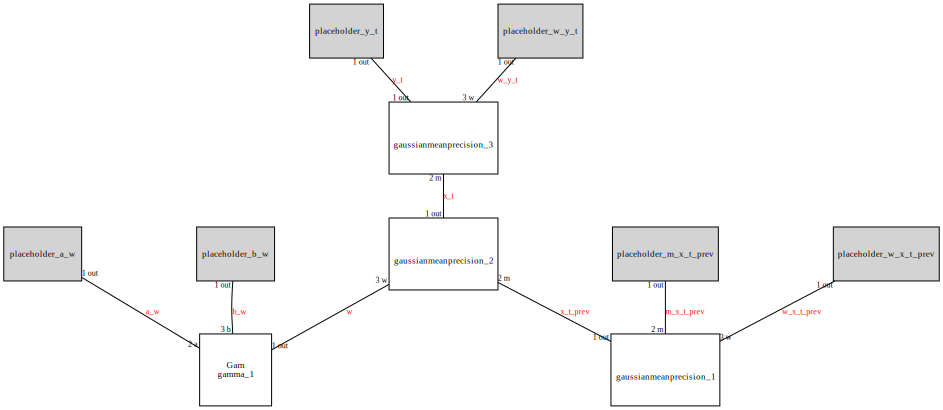

In [245]:
# Generate data first!

rwg = FactorGraph()

# declare priors as random variables
@RV a_w
@RV b_w
@RV m_x_t_prev
@RV w_x_t_prev
@RV w_y_t

@RV w ~ Gamma(a_w, b_w)
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV x_t ~ GaussianMeanPrecision(x_t_prev, w)
@RV y_t ~ GaussianMeanPrecision(x_t, w_y_t)

# Placeholders for prior
placeholder(a_w, :a_w)
placeholder(b_w, :b_w)
placeholder(m_x_t_prev, :m_x_t_prev)
placeholder(w_x_t_prev, :w_x_t_prev)

# Placeholder for data
placeholder(y_t, :y_t)
placeholder(w_y_t, :w_y_t)
ForneyLab.draw(rwg)

In [246]:
# Specify recognition factorization
q = RecognitionFactorization(x_t, w, ids=[:X_t :W])

# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)
algoF = freeEnergyAlgorithm()

eval(Meta.parse(algo))
eval(Meta.parse(algoF))

freeEnergy (generic function with 1 method)

In [247]:
# Define values for prior statistics
m_x_prev_0 = 0.0
w_x_prev_0 = 1.0
# FIXME
a_w_0 = 0.0001
b_w_0 = 0.0003

n_samples = length(y)
a_w = Vector{Float64}(undef, n_samples)
b_w = Vector{Float64}(undef, n_samples)
m_x = Vector{Float64}(undef, n_samples)
w_x = Vector{Float64}(undef, n_samples)

m_x_t_prev_min = m_x_prev_0
w_x_t_prev_min = w_x_prev_0
a_w_t_min = a_w_0
b_w_t_min = b_w_0;

In [248]:
data = Dict()
marginals = Dict()
n_its = 5

# Storage for score
FRW = []

# Storage for MSE and FE 
meansRW = []
varsRW = []

p = Progress(length(y), 1, "Observed ")
for t = 1:length(y)
    update!(p, t)
    marginals[:x_t_prev] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:w] = ProbabilityDistribution(Univariate, Gamma, a=a_w_t_min, b=b_w_t_min)
    global m_x_t_prev_min, w_x_t_prev_min, a_w_t_min, b_w_t_min, data
    
    for i = 1:n_its
        data = Dict(:y_t => y[t],
                    :w_y_t => huge,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min,
                    :a_w => a_w_t_min,
                    :b_w => b_w_t_min)
        
        stepX_t!(data, marginals)
        stepW!(data, marginals)
        m_x[t] = mean(marginals[:x_t])
        w_x[t] = var(marginals[:x_t])^-1
        a_w[t] = marginals[:w].params[:a]
        b_w[t] = marginals[:w].params[:b]
        
        m_x_t_prev_min = m_x[t]
        w_x_t_prev_min = w_x[t]
        a_w_t_min = a_w[t]
        b_w_t_min = b_w[t]
    end
    m = m_a_min'm_x_t_prev_min
    v = mean(marginals[:w])^-1
    push!(meansRW, m)
    push!(varsRW, v)
    push!(FRW, (freeEnergy(data, marginals)))
end

In [249]:
println("Noise")
println("real variance = ", v_x)
println("estimated variance = ", unsafeMean(marginals[:w])^-1)

Noise
real variance = 1.0
estimated variance = 3.1369637150104017


# Evaluation of AR

To assess the performance of our model, we use the following metric:
$$\frac{1}{p}\sum_{i=1}^p(\hat{x}_{T+i}-x_{T+i})^2$$
where
\begin{align*}
&\hat{x}_{T+1}=\sum_{i=1}^p m_{a_{i}}x_{T-i} \\
&\hat{x}_{T+2}=\sum_{i=1}^{p-1} m_{a_{i}}x_{T-i}+m_{a_{p}}\hat{x}_{T+1} \\
&\hat{x}_{T+3}=\sum_{i=1}^{p-2} m_{a_{i}}x_{T-i}+m_{a_{p}}\hat{x}_{T+2}+m_{a_{p-1}}\hat{x}_{T+1} \\
&\qquad \vdots \\ 
&\hat{x}_{T+p+1}=\sum_{i=1}^{p}m_{a_{i}}\hat{x}_{T+p-i} 
\end{align*}

and Free Energy:
$$F_t[q]\triangleq \int q(\mathbf{x}_t)\log\frac{q(\mathbf{x}_t)}{p(\mathbf{x}_t, y_t\big|\mathbf{y}_{1:t-1})}d\mathbf{x}_t$$

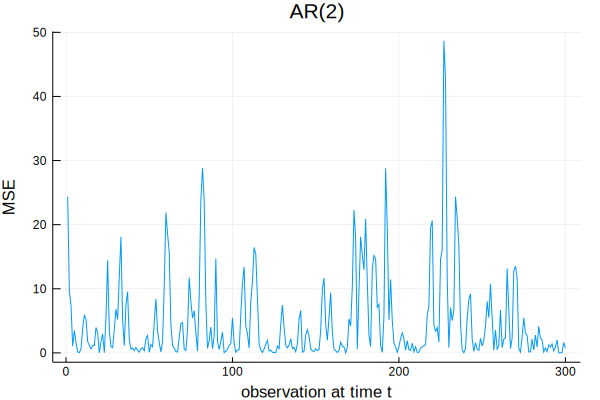

In [250]:
from = 1
upto = 300
plot(MSEsAR[from:upto], xlabel="observation at time t", ylabel="MSE", label="", title="AR($ARorder)")

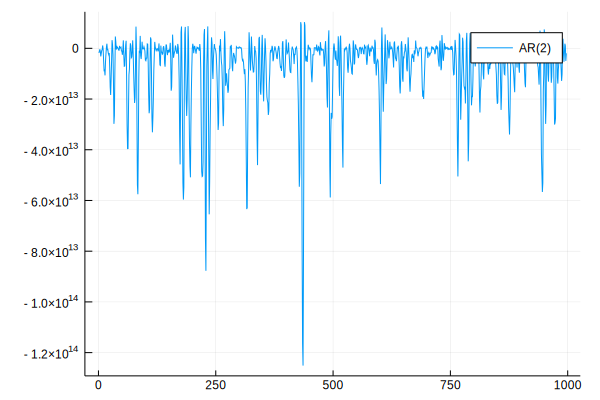

In [259]:
# Free energy
plot(FAR[2:end], label="AR($ARorder)")

# Amimation

In [263]:
# Plotting predictions
toshow = 10 # number of points to plot at once (length(predictions) - length(y) = 1)
scale = 1.0 # scale for the variance

anim = @animate for i in 1:length(means)-toshow-1
    s = plot(xticks = i:div(toshow, 2):i+toshow, xlims=(i,i+1.5*toshow));
    ylims!(minimum(y) - .1, maximum(y) + .1);
    scatter!(collect(i:i+toshow), y[i:i+toshow], xlabel="time T", ylabel="value", label="observation",
            markershape = :xcross, markeralpha = 0.9, markersize = 3)
    plot!(collect(i:i+toshow+1), means[i:i+toshow+1], ribbon=(sqrt.(vars[i:i+toshow+1]), sqrt.(vars[i:i+toshow+1])),
          linestyle=:dash, linewidth = 2,
          color=:orange,
          fillalpha = 0.2,
          fillcolor = :orange,
          label="predicted")
end;

In [264]:
gif(anim, "../gifs/ARpredict.gif", fps = 5)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/ARpredict.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/47Tik/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/ARpredict.gif")

In [261]:
# Plotting MSE
anim = @animate for i in 1:length(MSEsAR)
    s = plot()
    ylims!(minimum(MSEsAR) - 1, maximum(MSEsAR) + 1)
    xlims!(1, length(MSEsAR))
    plot!(collect(1:i), MSEsAR[1:i], xlabel="observation", ylabel="MSE", label="")
end;

In [262]:
gif(anim, "../gifs/MSEevo.gif", fps = 100)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/MSEevo.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/47Tik/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/MSEevo.gif")

In [257]:
# Plotting AR coefs
# !!! ONLY FOR AR(2)
using LinearAlgebra; 

len = 64

# Definition of the bivariate gaussian using a covariance matrix
𝓝(x, μ, Σ) = 1/((2 * π)^(length(μ)/2) * det(Σ)^(1/2)) * exp(-(1/2) * (x-μ)' * Σ^(-1) * (x-μ));

insert!(m_a, 1, m_a_0)
insert!(w_a, 1, 0.1*diagAR(ARorder))
anim = @animate for i in 1:1:length(m_a)
    if !isassigned(m_a, i)
        continue
    end
    s = plot();
    if coefs[1] < m_a_0[1]
        xlims!(coefs[1] - 0.42, m_a_0[1] + 0.42)
    else
        xlims!(m_a_0[1] - 0.42, coefs[1] + 0.42)
    end
    if coefs[2] < m_a_0[2]
        ylims!(coefs[2] - 0.42, m_a_0[2] + 0.42)
    else
        ylims!(m_a_0[2] - 0.42, coefs[2] + 0.42)
    end
    plot!([m_a_0[1]],[m_a_0[2]], seriestype=:scatter, title = "AR coefs (observation $i)", label="prior")
    plot!([coefs[1]],[coefs[2]], seriestype=:scatter, label="true")
    plot!([m_a[i][1]],[m_a[i][2]], seriestype=:scatter, label="posterior")
    
    # Posterior
    # get the maximum σ (used to construct the x and y ranges)
    σ_max = sqrt((w_a[i][1]^-1 > w_a[i][4]^-1 ) ? w_a[i][1]^-1 : w_a[i][4]^-1)
    rx = range(m_a[i][1]-3*σ_max, m_a[i][1]+3*σ_max, length=len)
    ry = range(m_a[i][2]-3*σ_max, m_a[i][2]+3*σ_max, length=len)
    contour!(rx, ry, (x1, x2) -> 𝓝([x1 ; x2], m_a[i], w_a[i]^-1), xlabel=L"\theta_1", ylabel=L"\theta_2")
end;

In [258]:
gif(anim, "../gifs/AR2coefsEVO.gif", fps = 10)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/AR2coefsEVO.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/47Tik/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/AR2coefsEVO.gif")